In [1]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.6 MB/s eta 0:00:00


In [2]:
pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 917.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 41.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=b8edc8ec861117150fb96b80f677d301987dbbc424f4d3839cfaa69919590f06
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [3]:
%%capture
!pip install langdetect

In [4]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 7.5 MB/s eta 0:00:00


In [5]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 18.5 MB/s eta 0:00:00


In [6]:
!pip install pyyaml==5.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [24]:
import numpy as np
import pandas as pd
import torch
import os
import json
import missingno as msno

#for detection of language
from langdetect import detect, DetectorFactory

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer

In [8]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_excel('/content/drive/My Drive/hacks/hack_nizh/CRA_train_1200.xlsx')
data

# Data preparation

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                1200 non-null   int64 
 1   pr_txt            1200 non-null   object
 2   Категория         1200 non-null   object
 3   Уровень рейтинга  1200 non-null   object
dtypes: int64(1), object(3)
memory usage: 37.6+ KB


<Axes: >

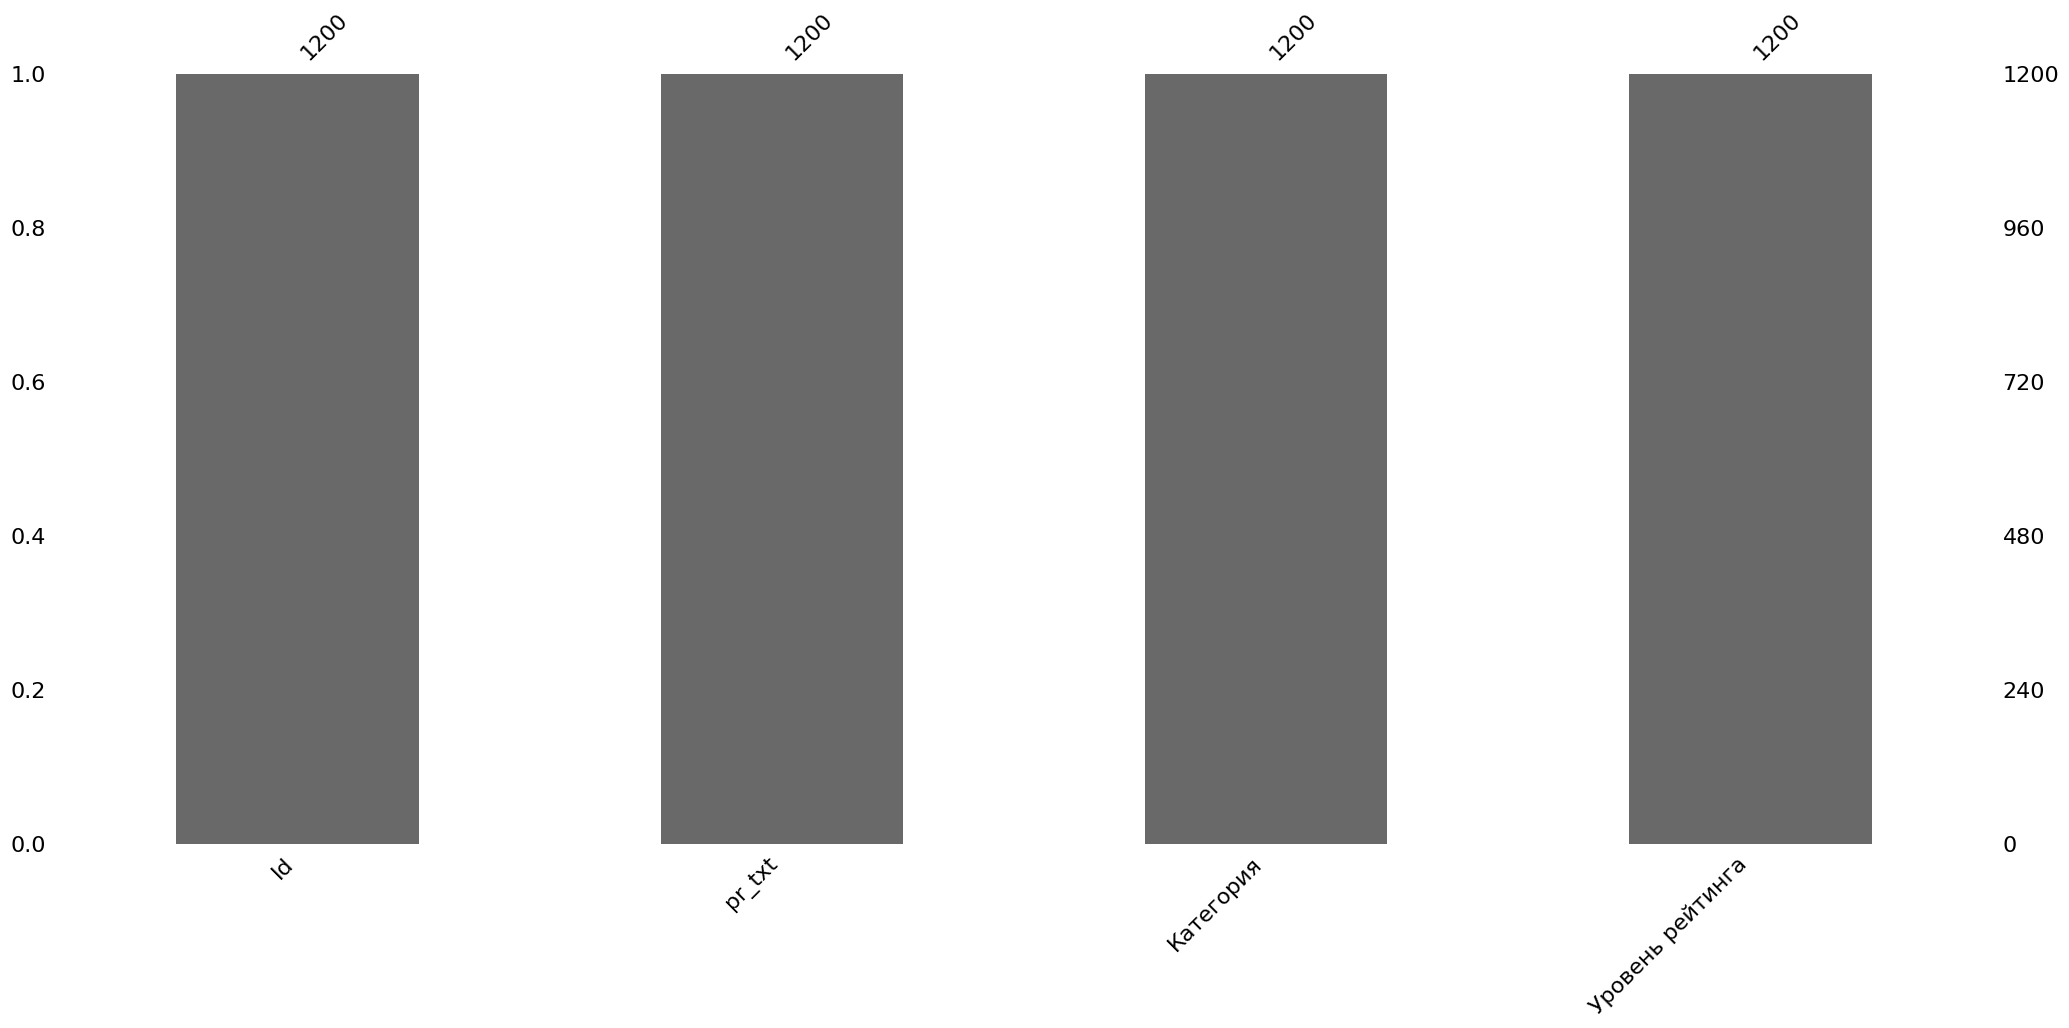

In [ ]:
msno.bar(data)

## Tags

In [ ]:
data['len_text'] = data.pr_txt.apply(lambda x: len(x.split(' ')))
data['len_text']

0       1190
1       1182
2       1393
3       1825
4       1178
        ... 
1195    1229
1196    1296
1197    1175
1198    1281
1199    1633
Name: len_text, Length: 1200, dtype: int64

# Preprocess text

In [10]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
# from string import puctuation

from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('omw-1.4')

import pymorphy2
morph = pymorphy2.MorphAnalyzer()
# stemmer = PorterStemmer()
# lemmatizer = WordNetLemmatizer()
import emoji

class Preprocess_text:
  @staticmethod
  def text_without_url(text):
    return re.sub(r'http\S+', '', text)

  @staticmethod
  def text_lowercase(text):
    # text = text_without_url(text)
    return text.lower()

  @staticmethod
  def remove_numbers(text):
    # text = text_lowercase(text)
    result = re.sub(r'\d+', '', text)
    return result

  @staticmethod
  def remove_punctuation(text):
    # text = remove_numbers(text)
    res = re.sub(r'[^\w\s]', '', text)
    return res

  @staticmethod
  def remove_whitespace(text):
    return  " ".join(text.split())

  @staticmethod
  def remove_emogi(text):
    # text = remove_whitespace(text)
    emoji_pattern = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)
    emoji_pattern = emoji_pattern.sub(r'', text)
    for elem in emoji_pattern:
      if emoji.is_emoji(elem) == True:
        emoji_pattern = emoji_pattern.replace(elem, '')
    return emoji_pattern

  @staticmethod
  def remove_stopwords(text):
    stop_words = set(stopwords.words("russian")+ stopwords.words('english')+['rating'])

    # filtered_text = [word for word in text if word not in stop_words] #after steming
    word_tokens = word_tokenize(text)  #after emogi
    filtered_text = [word for word in word_tokens if word not in stop_words] #after emogi
    return " ".join(filtered_text)

  @staticmethod
  def stem_words(text):
    stemmer = PorterStemmer()
    word_tokens = word_tokenize(text)
    stems = [stemmer.stem(word) for word in word_tokens]
    return stems

  @staticmethod
  def lemmatize_word(text):
    lemmatizer = WordNetLemmatizer()
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

  @staticmethod
  def inf_form(text):
    res = ''
    for i in text.split(' '):
        w = morph.parse(i)[0].normal_form
        res += str(w)
        res += ' '
    return res

  @staticmethod
  def rem_xm(text):

    return res

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
data['text_lowercase'] = data.pr_txt.apply(lambda x: Preprocess_text.text_lowercase(x))
data['text_without_url'] = data.text_lowercase.apply(lambda x: Preprocess_text.text_without_url(x))
data['remove_numbers'] = data.text_without_url.apply(lambda x: Preprocess_text.remove_numbers(x))
data['remove_punctuation'] = data.remove_numbers.apply(lambda x: Preprocess_text.remove_punctuation(x))
data['remove_emogi'] = data.remove_punctuation.apply(lambda x: Preprocess_text.remove_emogi(x))
data['remove_whitespace'] = data.remove_emogi.apply(lambda x: Preprocess_text.remove_whitespace(x))
data['inf_form'] = data.remove_whitespace.apply(lambda x: Preprocess_text.inf_form(x))
data['remove_stopwords'] = data.inf_form.apply(lambda x: Preprocess_text.remove_stopwords(x))

,Id,pr_txt,Категория,Уровень рейтинга,text_lowercase,text_without_url,remove_numbers,remove_punctuation,remove_emogi,remove_whitespace
0,1,Повышение кредитного рейтинга Акционерного об...,A,A,повышение кредитного рейтинга акционерного об...,повышение кредитного рейтинга акционерного об...,повышение кредитного рейтинга акционерного об...,повышение кредитного рейтинга акционерного об...,повышение кредитного рейтинга акционерного об...,повышение кредитного рейтинга акционерного общ...
1,2,«Эксперт РА» подтвердил кредитный рейтинг комп...,BB,BB,«эксперт ра» подтвердил кредитный рейтинг комп...,«эксперт ра» подтвердил кредитный рейтинг комп...,«эксперт ра» подтвердил кредитный рейтинг комп...,эксперт ра подтвердил кредитный рейтинг компан...,эксперт ра подтвердил кредитный рейтинг компан...,эксперт ра подтвердил кредитный рейтинг компан...
2,3,"НКР повысило кредитный рейтинг ООО ""ОТЭКО-Порт...",A,A,"нкр повысило кредитный рейтинг ооо ""отэко-порт...","нкр повысило кредитный рейтинг ооо ""отэко-порт...","нкр повысило кредитный рейтинг ооо ""отэко-порт...",нкр повысило кредитный рейтинг ооо отэкопортсе...,нкр повысило кредитный рейтинг ооо отэкопортсе...,нкр повысило кредитный рейтинг ооо отэкопортсе...
3,4,«Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...,AAA,AAA,«эксперт ра» присвоил кредитный рейтинг пао «ф...,«эксперт ра» присвоил кредитный рейтинг пао «ф...,«эксперт ра» присвоил кредитный рейтинг пао «ф...,эксперт ра присвоил кредитный рейтинг пао фоса...,эксперт ра присвоил кредитный рейтинг пао фоса...,эксперт ра присвоил кредитный рейтинг пао фоса...
4,5,29 марта 2023 г. Ведущий рейтинговый аналитик ...,BBB,BBB,29 марта 2023 г. ведущий рейтинговый аналитик ...,29 марта 2023 г. ведущий рейтинговый аналитик ...,марта г. ведущий рейтинговый аналитик юрова ...,марта г ведущий рейтинговый аналитик юрова а...,марта г ведущий рейтинговый аналитик юрова а...,марта г ведущий рейтинговый аналитик юрова алл...
...,...,...,...,...,...,...,...,...,...,...
1195,1207,«Эксперт РА» подтвердил рейтинг компании «Татн...,AAA,AAA,«эксперт ра» подтвердил рейтинг компании «татн...,«эксперт ра» подтвердил рейтинг компании «татн...,«эксперт ра» подтвердил рейтинг компании «татн...,эксперт ра подтвердил рейтинг компании татнефт...,эксперт ра подтвердил рейтинг компании татнефт...,эксперт ра подтвердил рейтинг компании татнефт...
1196,1208,«Эксперт РА» понизил рейтинг компании «Инвестг...,BB,BB,«эксперт ра» понизил рейтинг компании «инвестг...,«эксперт ра» понизил рейтинг компании «инвестг...,«эксперт ра» понизил рейтинг компании «инвестг...,эксперт ра понизил рейтинг компании инвестгеос...,эксперт ра понизил рейтинг компании инвестгеос...,эксперт ра понизил рейтинг компании инвестгеос...
1197,1209,АКРА подтвердило ПАО «КАМАЗ» кредитный рейтинг...,A,A+,акра подтвердило пао «камаз» кредитный рейтинг...,акра подтвердило пао «камаз» кредитный рейтинг...,акра подтвердило пао «камаз» кредитный рейтинг...,акра подтвердило пао камаз кредитный рейтинг r...,акра подтвердило пао камаз кредитный рейтинг r...,акра подтвердило пао камаз кредитный рейтинг r...
1198,1210,АКРА подтвердило кредитный рейтинг ФГУП «Почта...,AAA,AAA,акра подтвердило кредитный рейтинг фгуп «почта...,акра подтвердило кредитный рейтинг фгуп «почта...,акра подтвердило кредитный рейтинг фгуп «почта...,акра подтвердило кредитный рейтинг фгуп почта ...,акра подтвердило кредитный рейтинг фгуп почта ...,акра подтвердило кредитный рейтинг фгуп почта ...


In [ ]:
# data['result'] = data['remove_stopwords'].apply(lambda x: '' if len(x)==1 else x)
# data['result'] = data['result'].apply(lambda x: x.replace('х', ''))
# data['result'] = data['result'].apply(lambda x: x.replace('м', ''))


In [ ]:
data['result'][0]

'повышение кредитный рейтинг акционерный общество уральский сталь далее уральский сталь компания вызвать улучшение качественный оценка ликвидность связь рефинансирование краткосрочный банковский кредит посредством выпуск облигационный заём погашение год также пересмотр стратегический план реализация ряд инвестиционный проект способствовать улучшение показатель капитальный затрата выручка улучшение ценовой конъюнктура мировой рынок чугун обеспечить запуск доменный печь находиться ранее резерв оказать дополнительный положительный влияние денежный поток компания год кредитный рейтинг компания определяться средний рыночный позиция бизнеспрофиль уровень корпоративный управление также средний оценка размер бизнес показатель рентабельность ликвидность долгов нагрузка обслуживание долг денежный поток получить высокий оценка уральский сталь крупный россия производитель товарный чугун мостостать стать производство труба большой диаметр тбд начало год акционерный общество загорский трубный завод 

In [ ]:
for col in data.columns:
    print(col)
    print(data[col][0])

Id
1
pr_txt
Повышение кредитного рейтинга  Акционерного общества «Уральская сталь»  (далее — «Уральская сталь», Компания) вызвано улучшением качественной оценки ликвидности в связи с рефинансированием краткосрочного банковского кредита посредством выпуска облигационного займа с погашением в 2025 году. Также пересмотр стратегических планов по реализации ряда инвестиционных проектов способствовал улучшению показателя «капитальные затраты к выручке». Улучшение ценовой конъюнктуры на мировом рынке чугуна обеспечило запуск доменной печи №3, находившейся ранее в резерве, что окажет дополнительное положительное влияние на денежный поток Компании в 2023 году.   Кредитный рейтинг Компании определяется средними рыночной позицией, бизнес-профилем и уровнем корпоративного управления, а также средней оценкой за размер бизнеса. Показатели рентабельности, ликвидности, долговой нагрузки, обслуживания долга и денежного потока получили высокие оценки.   «Уральская сталь» — один из крупнейших в России пр

In [ ]:
data.columns

Index(['Id', 'pr_txt', 'Категория', 'Уровень рейтинга', 'text_lowercase',
       'text_without_url', 'remove_numbers', 'remove_punctuation',
       'remove_emogi', 'remove_whitespace', 'inf_form', 'remove_stopwords',
       'result'],
      dtype='object')

In [ ]:
data = data.drop(['text_lowercase',
                  'text_without_url',
                  'remove_numbers',
                  'remove_punctuation',
                  'remove_emogi',
                  'remove_whitespace',
                  'inf_form',
                  'result'], axis=1)

In [ ]:
data

,Id,pr_txt,Категория,Уровень рейтинга,remove_stopwords
0,1,Повышение кредитного рейтинга Акционерного об...,A,A,повышение кредитный рейтинг акционерный общест...
1,2,«Эксперт РА» подтвердил кредитный рейтинг комп...,BB,BB,эксперт ра подтвердить кредитный рейтинг компа...
2,3,"НКР повысило кредитный рейтинг ООО ""ОТЭКО-Порт...",A,A,нкр повысить кредитный рейтинг ооо отэкопортсе...
3,4,«Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...,AAA,AAA,эксперт ра присвоить кредитный рейтинг пао фос...
4,5,29 марта 2023 г. Ведущий рейтинговый аналитик ...,BBB,BBB,март г ведущий рейтинговый аналитик юров алла ...
...,...,...,...,...,...
1195,1207,«Эксперт РА» подтвердил рейтинг компании «Татн...,AAA,AAA,эксперт ра подтвердить рейтинг компания татнеф...
1196,1208,«Эксперт РА» понизил рейтинг компании «Инвестг...,BB,BB,эксперт ра понизить рейтинг компания инвестгео...
1197,1209,АКРА подтвердило ПАО «КАМАЗ» кредитный рейтинг...,A,A+,акр подтвердить пао камаз кредитный рейтинг пр...
1198,1210,АКРА подтвердило кредитный рейтинг ФГУП «Почта...,AAA,AAA,акр подтвердить кредитный рейтинг фгуп почта р...


In [ ]:
data.to_excel('/content/drive/My Drive/hacks/hack_nizh/prep_data.xlsx')

# Выделение цифр из текста

In [26]:
data = pd.read_excel('/content/drive/My Drive/hacks/hack_nizh/prep_data.xlsx')

In [13]:
data['remove_punctuation'] = data.pr_txt.apply(lambda x: Preprocess_text.remove_punctuation(x))


In [14]:

word_list = data['remove_punctuation'][0].split()


In [51]:
num_list = {}
w_zero = {}
w_first = {}
w_second = {}
w_third = {}
for i in range(len(word_list)):
    if i == 0 and word_list[i].isnumeric():
        w_zero[i] = '-'
        w_first[i] = '-'
        w_second[i] = word_list[i+1]
        w_third[i] = word_list[i+2]
    elif i == 1 and word_list[i].isnumeric():
        w_zero[i] = '-'
        w_first[i] = word_list[i-1]
        w_second[i] = word_list[i+1]
        w_third[i] = word_list[i+2]
    elif i == (len(word_list)-1) and word_list[i].isnumeric():
        w_zero[i] = word_list[i-2]
        w_first[i] = word_list[i-1]
        w_second[i] = '-'
        w_third[i] = '-'
    elif (i!=0) and (i!=(len(word_list)-1)) and (word_list[i].isnumeric()):
        num_list[i] = (int(word_list[i]))
        w_zero[i] = word_list[i-2]
        w_first[i] = word_list[i-1]
        w_second[i] = word_list[i+1]
        w_third[i] = word_list[i+2]

In [52]:
for k, i, n, j, g in zip(w_zero, w_first, num_list, w_second, w_third):
    print(w_zero[k], w_first[i], num_list[n], w_second[j], w_third[g])
    print('///////////////////////////////')

погашением в 2025 году Также
///////////////////////////////
доменной печи 3 находившейся ранее
///////////////////////////////
Компании в 2023 году Кредитный
///////////////////////////////
В начале 2022 года Акционерное
///////////////////////////////
ЗТЗ приобрело 100 уставного капитала
///////////////////////////////
формирует до 50 консолидированной выручки
///////////////////////////////
налогов за 2022 год составила
///////////////////////////////
год составила 12 и ожидается
///////////////////////////////
уровне около 18 в 2023м
///////////////////////////////
по результатам 2022 года и
///////////////////////////////
по результатам 2023 года средней
///////////////////////////////
налогов менее 30 млрд руб
///////////////////////////////
В декабре 2022 года Компания
///////////////////////////////
погашением в 2025 году АКРА
///////////////////////////////
по результатам 2023 года Высокая
///////////////////////////////
на горизонте 1218 месяцев К
////////////////////////////

In [54]:
from transformers import pipeline
p = pipeline(
  task='zero-shot-classification',
  model='cointegrated/rubert-base-cased-nli-twoway'
)


In [56]:
p(
  sequences="объем эмиссии 10 млрд руб",
  candidate_labels="Мне понравилось, Мне не понравилось",
  hypothesis_template="{}.")

{'sequence': 'объем эмиссии 10 млрд руб',
 'labels': ['Мне понравилось', 'Мне не понравилось'],
 'scores': [0.6100800037384033, 0.3899199664592743]}

In [57]:
p(
  sequences="срок погашения 25122025 объем эмиссии",
  candidate_labels="Мне понравилось, Мне не понравилось",
  hypothesis_template="{}.")

{'sequence': 'срок погашения 25122025 объем эмиссии',
 'labels': ['Мне понравилось', 'Мне не понравилось'],
 'scores': [0.6378627419471741, 0.3621372580528259]}

In [58]:
p(
  sequences="налогов выше 30 млрд руб",
  candidate_labels="Мне понравилось, Мне не понравилось",
  hypothesis_template="{}.")

{'sequence': 'налогов выше 30 млрд руб',
 'labels': ['Мне понравилось', 'Мне не понравилось'],
 'scores': [0.5279799103736877, 0.4720200300216675]}

# Наиболее часто встречающиеся слова

In [17]:
data.head()

,Unnamed: 0,Id,pr_txt,Категория,Уровень рейтинга,remove_stopwords,remove_punctuation
0,0,1,Повышение кредитного рейтинга Акционерного об...,A,A,повышение кредитный рейтинг акционерный общест...,Повышение кредитного рейтинга Акционерного об...
1,1,2,«Эксперт РА» подтвердил кредитный рейтинг комп...,BB,BB,эксперт ра подтвердить кредитный рейтинг компа...,Эксперт РА подтвердил кредитный рейтинг компан...
2,2,3,"НКР повысило кредитный рейтинг ООО ""ОТЭКО-Порт...",A,A,нкр повысить кредитный рейтинг ооо отэкопортсе...,НКР повысило кредитный рейтинг ООО ОТЭКОПортсе...
3,3,4,«Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...,AAA,AAA,эксперт ра присвоить кредитный рейтинг пао фос...,Эксперт РА присвоил кредитный рейтинг ПАО ФосА...
4,4,5,29 марта 2023 г. Ведущий рейтинговый аналитик ...,BBB,BBB,март г ведущий рейтинговый аналитик юров алла ...,29 марта 2023 г Ведущий рейтинговый аналитик Ю...


In [27]:
text_all = ''
for i in data['remove_stopwords']:
    text_all += i

In [ ]:
from nltk import word_tokenize
import nltk
from nltk.probability import FreqDist

In [31]:
# text = data['remove_stopwords'][0]
text = text_all
# токенизируем текст
text_tokens = word_tokenize(text)
# переводим токены в текстовый формат
text = nltk.Text(text_tokens)
# и считаем слова в тексте по популярности
fdist = FreqDist(text)
# выводим первые 5 популярных слов
print(fdist.most_common(100))

[('рейтинг', 26426), ('компания', 24977), ('год', 17629), ('кредитный', 15881), ('ао', 13464), ('ра', 11878), ('уровень', 11663), ('эксперт', 11236), ('рейтинговый', 10084), ('агентство', 9845), ('являться', 9227), ('группа', 8885), ('также', 7863), ('высокий', 7538), ('оценка', 7259), ('информация', 6647), ('долг', 6021), ('который', 5632), ('руб', 5573), ('прогноз', 5499), ('млрд', 5313), ('финансовый', 5217), ('ооо', 5211), ('показатель', 5048), ('объём', 4902), ('присвоение', 4730), ('мнение', 4494), ('процентный', 4446), ('платёж', 4300), ('составить', 4282), ('рост', 4154), ('х', 4142), ('присвоить', 4093), ('пао', 4033), ('выручка', 4008), ('риск', 4004), ('рынок', 3934), ('акр', 3888), ('дата', 3888), ('оказывать', 3802), ('рентабельность', 3731), ('комитет', 3610), ('отношение', 3599), ('нагрузка', 3563), ('российский', 3563), ('чистый', 3559), ('методология', 3538), ('это', 3503), ('рамка', 3425), ('обязательство', 3387), ('период', 3380), ('фактор', 3354), ('ликвидность', 33

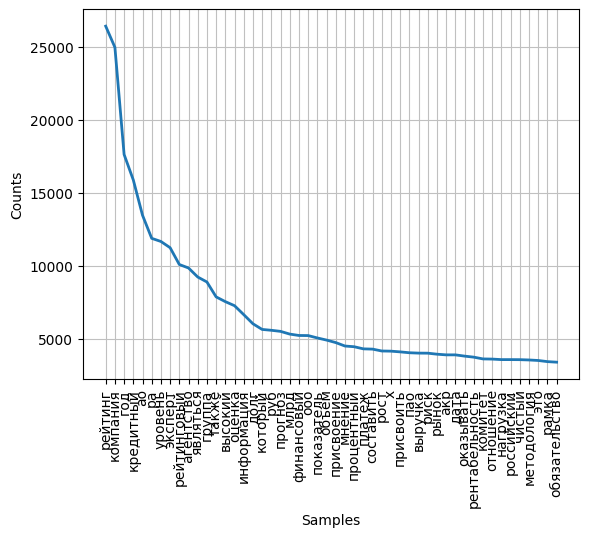

<Axes: xlabel='Samples', ylabel='Counts'>

In [33]:
fdist.plot(50,cumulative=False)

In [36]:
fdist

FreqDist({'рейтинг': 26426, 'компания': 24977, 'год': 17629, 'кредитный': 15881, 'ао': 13464, 'ра': 11878, 'уровень': 11663, 'эксперт': 11236, 'рейтинговый': 10084, 'агентство': 9845, ...})

In [40]:
frec = pd.DataFrame(fdist.items(), columns=['word', 'frequency'])

In [41]:
frec

,word,frequency
0,повышение,717
1,кредитный,15881
2,рейтинг,26426
3,акционерный,641
4,общество,609
...,...,...
11724,авиалайнер,1
11725,ный,1
11726,ст,1
11727,пересылать,1


In [42]:
frec.to_excel('/content/drive/My Drive/hacks/hack_nizh/frec.xlsx')

In [43]:
print(fdist.most_common(5000))

[('рейтинг', 26426), ('компания', 24977), ('год', 17629), ('кредитный', 15881), ('ао', 13464), ('ра', 11878), ('уровень', 11663), ('эксперт', 11236), ('рейтинговый', 10084), ('агентство', 9845), ('являться', 9227), ('группа', 8885), ('также', 7863), ('высокий', 7538), ('оценка', 7259), ('информация', 6647), ('долг', 6021), ('который', 5632), ('руб', 5573), ('прогноз', 5499), ('млрд', 5313), ('финансовый', 5217), ('ооо', 5211), ('показатель', 5048), ('объём', 4902), ('присвоение', 4730), ('мнение', 4494), ('процентный', 4446), ('платёж', 4300), ('составить', 4282), ('рост', 4154), ('х', 4142), ('присвоить', 4093), ('пао', 4033), ('выручка', 4008), ('риск', 4004), ('рынок', 3934), ('акр', 3888), ('дата', 3888), ('оказывать', 3802), ('рентабельность', 3731), ('комитет', 3610), ('отношение', 3599), ('нагрузка', 3563), ('российский', 3563), ('чистый', 3559), ('методология', 3538), ('это', 3503), ('рамка', 3425), ('обязательство', 3387), ('период', 3380), ('фактор', 3354), ('ликвидность', 33

16
[('рейтинг', 2358), ('компания', 2291), ('год', 1821), ('кредитный', 1395), ('ао', 1336), ('ра', 1154), ('эксперт', 1091), ('уровень', 1047), ('группа', 953), ('рейтинговый', 916), ('агентство', 882), ('являться', 820), ('также', 769), ('оценка', 712), ('долг', 654), ('высокий', 618), ('платёж', 566), ('млрд', 561), ('информация', 539), ('процентный', 518), ('руб', 505), ('который', 497), ('прогноз', 477), ('финансовый', 471), ('акр', 450), ('рост', 450), ('х', 441), ('присвоение', 436), ('показатель', 431), ('мнение', 421), ('отношение', 418), ('объём', 418), ('ffo', 410), ('это', 408), ('чистый', 408), ('выручка', 405), ('рамка', 383), ('составить', 378), ('присвоить', 375), ('рынок', 366)]


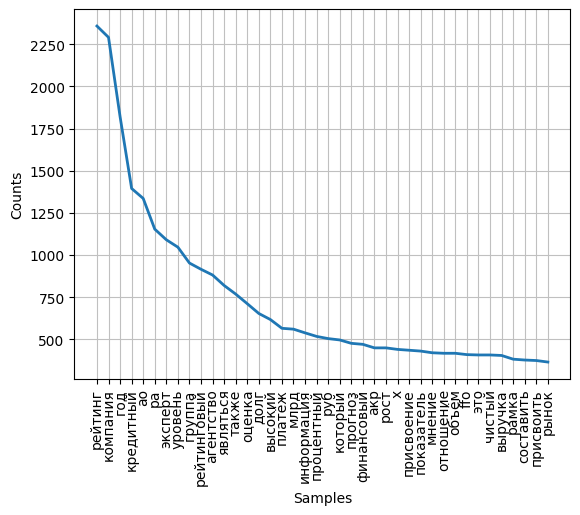

эксперт ра подтвердить рейтинг компания эталон ленспецсм уровень москва апрель г рейтинговый агентство эксперт ра подтвердить рейтинг кредитоспособность нефинансовый компания эталон ленспецсм уровень прогноз рейтинг стабильный ао эталон ленспецсм далее эталон ленспецсм компания являться крупный девелопер жилой недвижимость рф осуществлять вместе дочерний компания деятельность г санктпетербург московский регион компания входить группа эталон далее гк эталон группа основать год акция который торговаться лондонский фондовый биржа агентство сохранять позитивный оценка профиль бизнесриск компания эталон ленспецсм консолидировать всё строительный проект гк эталон санктпетербург пять московский проект который сдать эксплуатация компания традиционно характеризоваться свой сильный конкурентный позиция рынок первичный жильё санктпетербург оценка агентство начало апрель год компания входить топ застройщик санктпетербург объём текущий строительство эталон ленспецсм находиться текущий строительство

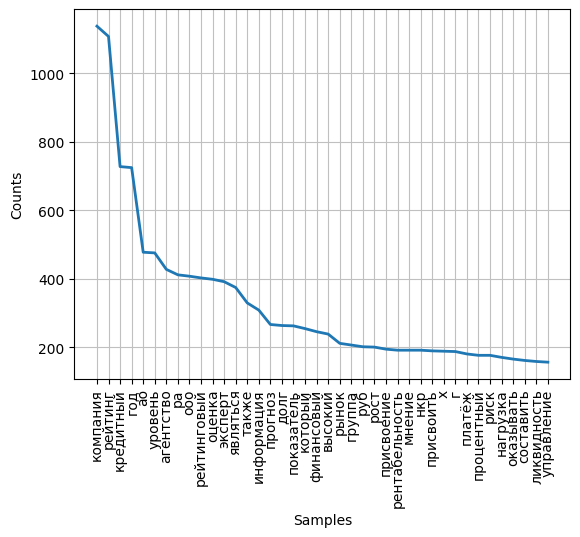

эксперт ра понизить рейтинг компания инвестгеосервис уровень изменить прогноз развивающийся установить статус наблюдение москва апрель г рейтинговый агентство эксперт ра понизить рейтинг кредитоспособность нефинансовый компания инвестгеосервис уровень рейтинг установить развивающийся прогноз статус наблюдение означать высокий вероятность рейтинговый действие близкий месяц ранее компания действовать рейтинг уровень стабильный прогноз ао инвестгеосервис далее компания специализироваться оказание услуга строительство нефтяной газовый скважина янао красноярский край республика коми иркутский область выручка компания итог год приходиться исполнение контракт янао якорный заказчик являться пао новатэк стаб ассоциированный компания оао ямал спг ао арктикгаз стаб агентство позитивный оценивать географический диверсификация бизнес компания разрез выполнять проект доля крупный проект ямал спг итог год приходиться треть выручка это сдерживать влияние рейтинг попрежний оказывать концентрация деятел

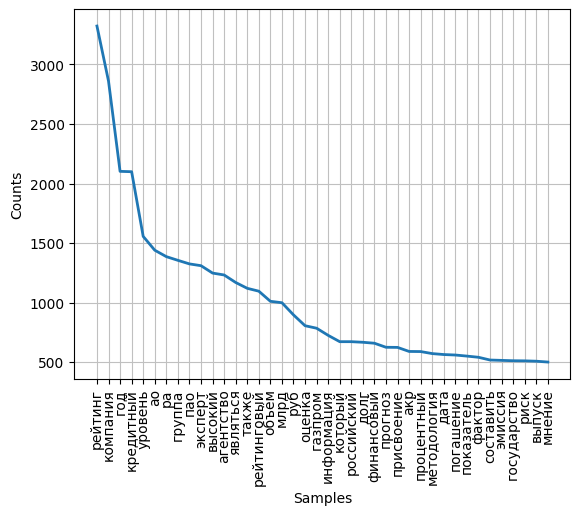

акр подтвердить кредитный рейтинг фгуп почта россия уровень прогноз стабильный рейтинг облигация уровень кредитный рейтинг фгуп почта россия далее почта россия компания обусловить очень высокий уровень системный значимость организация российский экономика очень высокий степень влияние государство согласно методология акр также очень сильный рыночный позиция компания сильный бизнеспрофиль средний уровень корпоративный управление обусловить организационноправовой форма компания крупный размер средний рентабельность долгов нагрузка сдерживать влияние уровень оценка собственный кредитоспособность оск почта россия оказывать средний показатель ликвидность умеренный показатель денежный поток низкий покрытие процент почта россия оператор российский государственный почтовый сеть осуществлять деятельность весь регион страна компания оказывать всё вид услуга почтовый связь доставка письменный корреспонденция почтовый отправление международный почтовый связь далее осуществлять денежный перевод дос

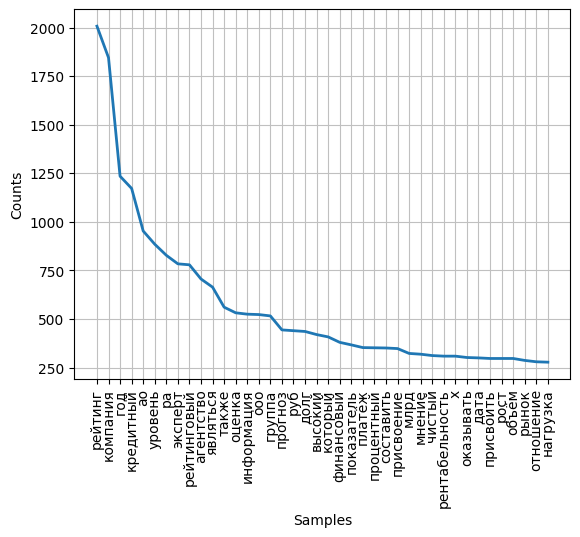

эксперт ра подтвердить рейтинг компания главстройспб специализировать застройщик уровень москва июнь г рейтинговый агентство эксперт ра подтвердить рейтинг кредитоспособность нефинансовый компания главстройспб специализировать застройщик уровень прогноз рейтинг стабильный ооо главстройспб специализировать застройщик далее компания являться крупный застройщик рынок санктпетербург московский область год компания ввести эксплуатация тыс кв м жилой недвижимость проект северный долина составлять около весь объём жильё ввести эксплуатация г санктпетербург г компания также ввести прошлый год тыс кв м жилой недвижимость проект столичный г железнодорожный составлять около весь объём жильё ввести эксплуатация г московский область основный фактор влиять бизнес компания являться изменение правило финансирование строительство жильё который вступать сила средство население привлекать новый проект специальный счёт эскроусчёт который застройщик смочь получить средство окончание строительство финансиро

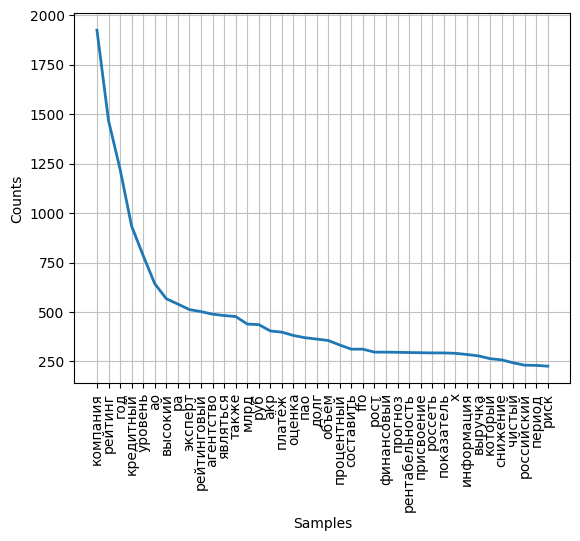

эксперт ра подтвердить рейтинг компания российский автомобильный дорога уровень москва май г рейтинговый агентство эксперт ра подтвердить рейтинг кредитоспособность нефинансовый компания российский автомобильный дорога уровень прогноз рейтинг стабильный государственный компания российский автомобильный дорога далее гк автодора компания некоммерческий организация создать год основание федеральный закон фз доверительный управление передать автомобильный дорога общий пользование федеральный значение текущий момент компания управлять федеральный автомобильный дорога м беларусь м украина м дон участок дорога также реализовать проект строительство дорога м москва санктпетербург центральный кольцевой автомобильный дорога цкада являться непосредственный заказчик работа отдельный участок автодорога компания также исполнять роль публичный сторона соглашение формат государственночастный партнёрство гчп который компания реализовать часть проект строительство реконструкция автодорога состояние комп

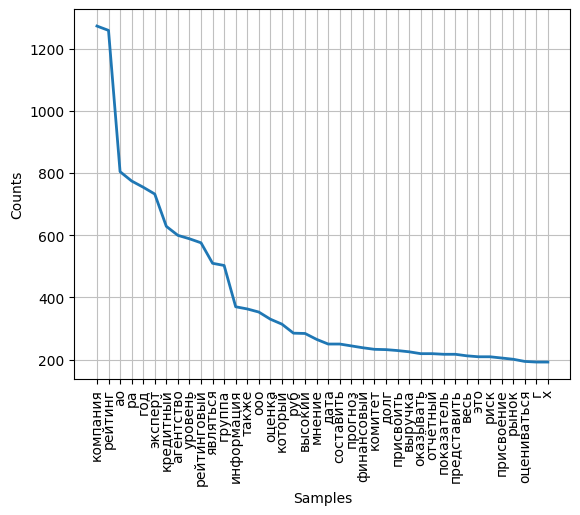

эксперт ра подтвердить рейтинг компания сибинтечь уровень москва апрель г рейтинговый агентство эксперт ра подтвердить рейтинг кредитоспособность нефинансовый компания сибинтечь уровень прогноз рейтинг стабильный ооо ик сибинтечь оказывать итуслуга компания группа роснефть ряд сторонний заказчик текущий портфель заказ проект услуга компания гк роснефть область ит автоматизация управление технологический процесс метрология занимать существенный часть оценка агентство порядок выручка итог год приходиться проект кроме компания заключить ряд договор поставка оборудование фгуп почта россия фонд социальный страхование рф департамент информационный технология город москва ао райффайзенбанк сибинтечь входить группа крупный компания отрасль выручка демонстрировать высокий темп рост среди компания специализироваться информационный технология крупный российский нефтегазовый металлургический телекоммуникационный группа связь конкурентный позиция компания оказывать позитивный влияние уровень рейтин

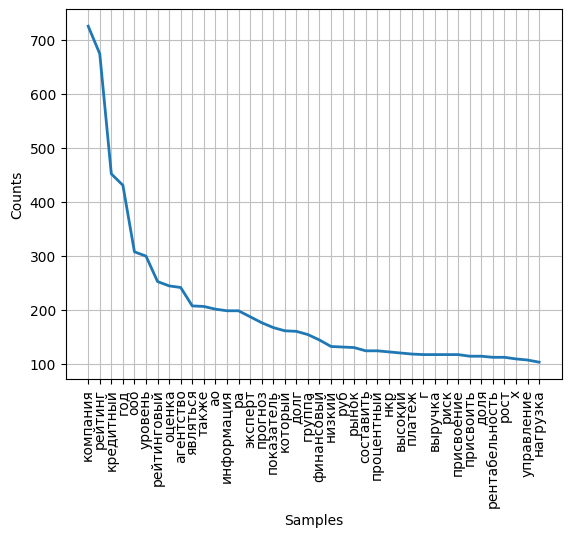

эксперт ра подтвердить рейтинг компания пао гит уровень изменить прогноз негативный москва июнь г рейтинговый агентство эксперт ра подтвердить рейтинг кредитоспособность нефинансовый компания городской инновационный технология уровень изменить прогноз рейтинг негативный пао гит далее компания холдинг являться холдинговый структура объединять компания область управление объект недвижимость оказание услуга сфера жкх состояние июнь год управление компания находиться млн квм компания работать г санктпетербург ленинградский область ряд регион рф уровень диверсификация выручка оцениваться агентство умеренно низкий итог год выручка сформировать территория г санктпетербург ленинградский область перспектива развитие отрасль попрежний ограничить ввиду невысокий темп рост жилищный фонд невозможность повышение тариф сверх предельный индекс утверждать государство рынок услуга сфера жкх оставаться деконцентрированный позволять компания существенно нарастить свой рыночный доля ограничивать конкурентн

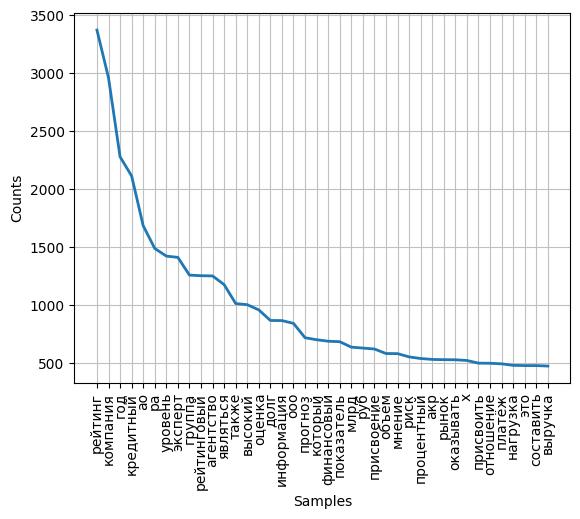

эксперт ра продлить статус наблюдение рейтинг компания первый коллекторский бюро москва май г рейтинговый агентство эксперт ра продлить статус наблюдение рейтинг кредитоспособность финансовый компания первый коллекторский бюро означать высокий вероятность рейтинговый действие близкий время рейтинг компания продолжать действовать уровень стабильный прогноз нао первый коллекторский бюро далее компания основный компания группа fcb group limited далее группа лидер российский рынок коллекторский услуга доля рынок накопить объём задолженность баланс состав группа также входить приобрести год ооо национальный служба взыскание который специализироваться взыскание проблемный задолженность агентский схема время компания самостоятельно приобретать портфель задолженность банковцедент взыскивать должник использование метод soft field legal применять гибкий система дисконт установление статус наблюдение обусловить задержание генеральный директор компания менеджмент контролировать акционер компания и

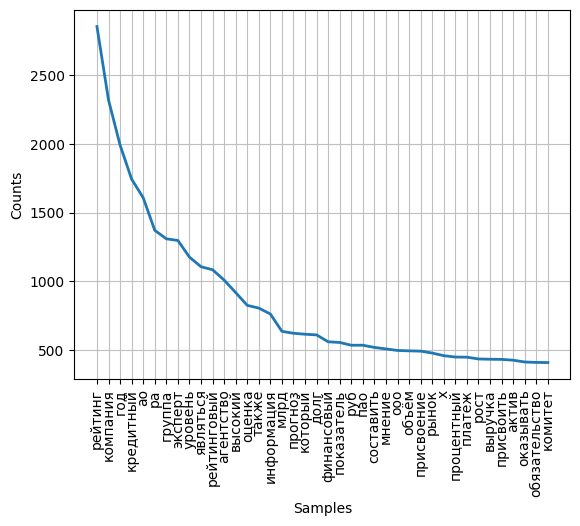

акр подтвердить пао камаз кредитный рейтинг прогноз стабильный подтвердить рейтинг облигация кредитный рейтинг пао камаз далее компания камаз обусловить высокий уровень системный значимость компания российский экономика высокий степень влияние государство согласно методология акр кроме компания иметь сильный рыночный позиция высокий уровень корпоративный управление сильный географический диверсификация сильный ликвидность средний показатель оценка бизнеспрофиль размер рентабельность бизнес долгов нагрузка обслуживание долг сдерживать влияние уровень кредитный рейтинг оказывать слабый показатель денежный поток обусловить настоящий время компания проходить пик инвестиционный цикл камаз лидировать компания российский рынок грузовой автомобиль год доля камаз сегмент автомобиль грузоподъёмность тонна составить число рынок шасси спецтехник самосвал бортовый автомобиль седельный тягач ч магистральный седельный тягач ключевой фактор рейтинговый оценка системный значимость камаз степень влияние

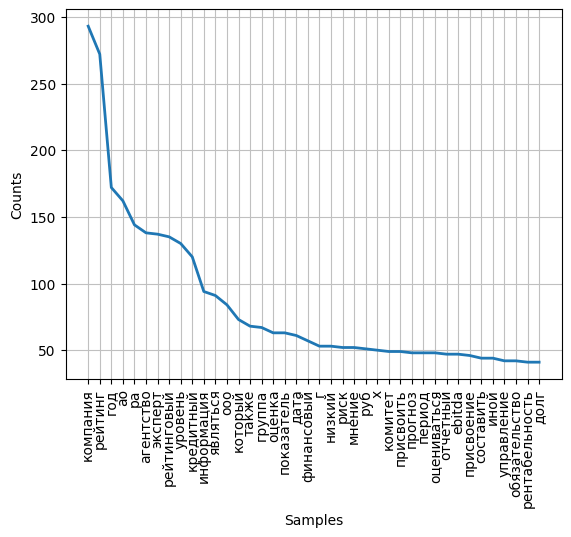

эксперт ра присвоить кредитный рейтинг компания литана уровень москва август г рейтинговый агентство эксперт ра присвоить рейтинг кредитоспособность нефинансовый компания литана уровень прогноз рейтинг стабильный ооо литана далее литана компания российский компания основный направление деятельность который являться организация управление строительство объект промышленный гражданский назначение проектирование строительство компания входить международный холдинг литана гк литана холдинг центральный офис который находиться литва гк литана являться постоянный партнёр крупный предприятие европа также крупный производитель строительный металлоконструкция балтийский регион российский ооо литана вывести периметр гк литана связь требование европейский банк предоставление большой количество информация дочерний компания предмет санкционный риск настоящий момент компания вести бизнес автономно гк литана осуществлять самостоятельный поиск заказ исполнение использование технологический маркетинговый

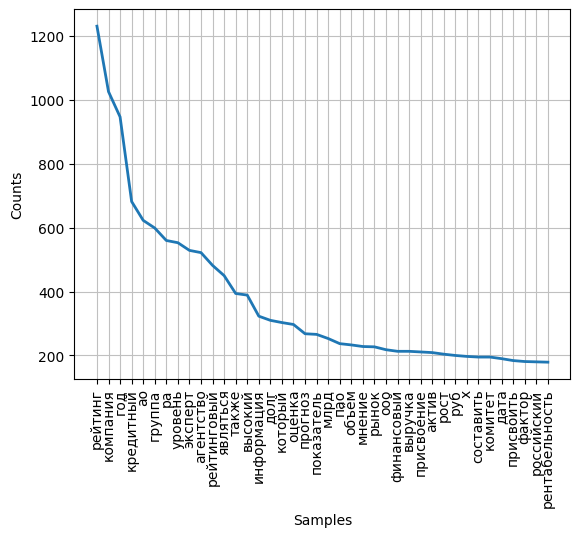

эксперт ра подтвердить рейтинг компания суэк уровень москва июнь г рейтинговый агентство эксперт ра подтвердить рейтинг кредитоспособность нефинансовый компания суэк уровень прогноз рейтинг стабильный ао суэк далее суэк компания являться крупный угольный компания россия занимать первый место объём добыча год компания добыть млн тонна уголь половина который год ранее направить экспорт страна атлантический азиатскотихоокеанский регион итог год компания входить топ мир объём добыча уголь занимать четвёртый место объём продажа уголь международный рынок угольный актив компания насчитывать шахта угольный разрез обогатительный фабрика установка основный производственный база точка зрение запас объём добыча уголь расположить х регион сибирский федеральный округ кемеровский область хакасия красноярский край тн кузбасский угольный бассейн август год суэк консолидировать сибирский генерировать компания далее сгк который ранее принадлежать акционер суэк сгк владеть тэс сибирский федеральный округ 

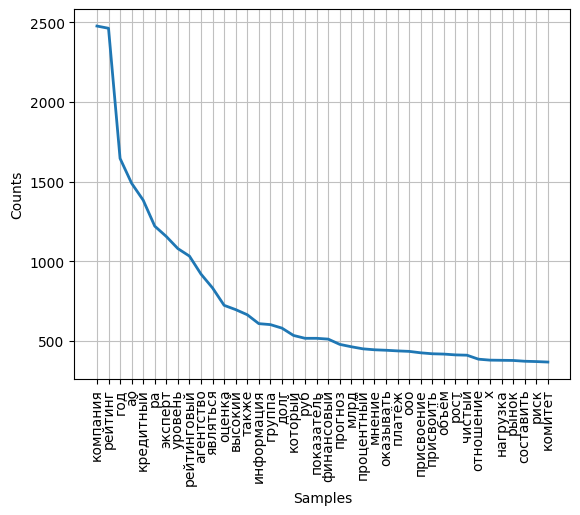

акр присвоить ао загорский трубный завод кредитный рейтинг прогноз стабильный кредитный рейтинг ао загорский трубный завод далее зтз компания обусловить сильный рыночный позиция средний бизнеспрофиль средний уровень корпоративный управление низкий долгов нагрузка также высокий покрытие процент сдерживать влияние уровень рейтинг зтз оказывать средний рентабельность размер также умеренный показатель денежный поток ликвидность зтз лидер российский рынок объём отгрузка труба большой диаметр тбд общий объём производство дать продукция итог год основный вид деятельность компания являться производство электросварной тбд нефте газопровод также компания производить труба пенополиуретановый ппу изоляция год выручка компания рсб превысить млрд руб объём производство основный товар тбд вырасти сравнение предыдущий год тыс тонна год против тыс тонна м зтз являться ключевой актив компания крупный производственный актив отсутствовать штат компания составлять человек контрольный пакет акция принадлежа

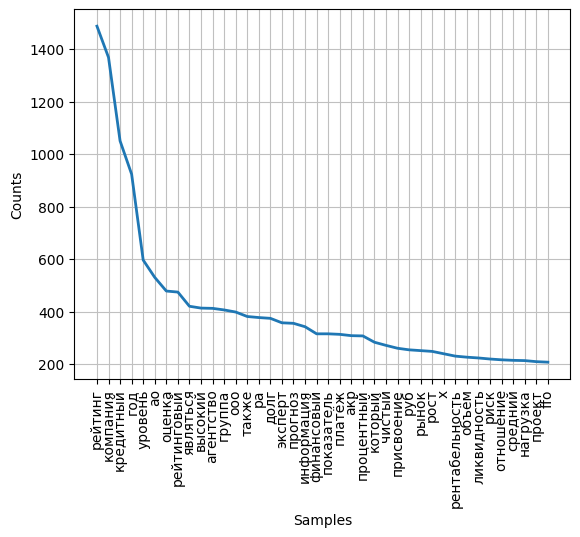

эксперт ра понизить рейтинг компания русский аквакультура уровень москва июнь г рейтинговый агентство эксперт ра понизить рейтинг кредитоспособность нефинансовый компания русский аквакультура уровень прогноз рейтинг стабильный ранее компания действовать рейтинг уровень стабильный прогноз пао русский аквакультура головной компания группа русский аквакультура далее группа консолидировать аквакультурный актив территория россия состав ооо русский море аквакультура также завод производство смолт территория норвегия основной производственный мощность группа сосредоточить г мурманск функционировать семь ферма выращивание лосось форель сервисный служба иметься собственный живорыбный судно сухогруз доставка корм группа также заниматься выращивание радужный форель территория карелия понижение рейтинг обусловить существенный рост капитальный затрата долговой портфель найти свой отражение переоценка агентство среднее прогнозный свободный денежный поток группа соответствовать влияние фактор прогноз

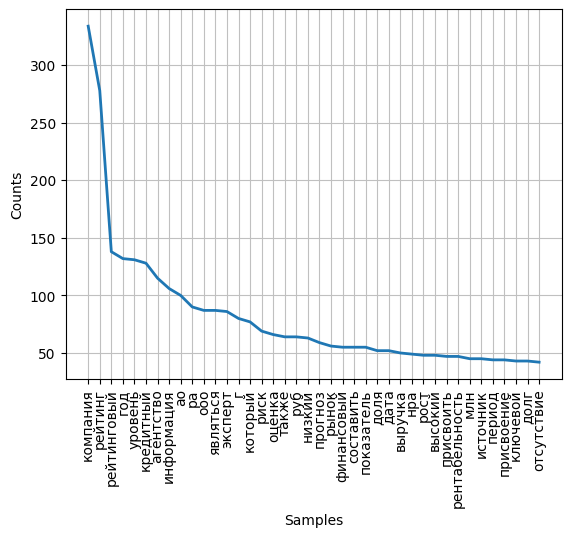

май г ведущий рейтинговый аналитик мария сулим директор рейтинг финансовый компания sulimaranationalru второй рейтинговый аналитик алла юров аналитик корпоративный рейтинг yurovaranationalru дата рейтинговый комитет г присвоить кредитный рейтинг ооо национальный рейтинговый агентство далее нра агентство присвоить кредитный рейтинг ао русский контейнерный компания ао ркк уровень национальный рейтинговый шкала российский федерация прогноз рейтинг развивающийся прогноз развивающийся прогноз предполагать пересмотр текущий уровень рейтинг течение следующий месяц резюме кредитный рейтинг далее рейтинг ао ркк далее компания уровень ограничиваться влияние внешний бизнесриск высокий волатильность транспортный отрасль небольшой доля рынок низкий уровень раскрытие финансовый информация наличие повышенный финансовый риск ограниченный узнаваемость бренд недлительный срок работа рынок усложнить структура собственность компания поддержка рейтинг оказывать умеренный уровень финансовый леверидж пермане

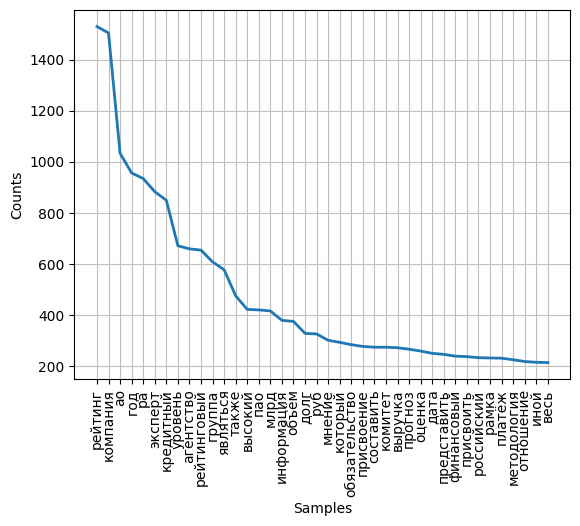

эксперт ра подтвердить рейтинг компания энела россия уровень москва апрель г рейтинговый агентство эксперт ра подтвердить рейтинг кредитоспособность нефинансовый компания энела россия уровень прогноз рейтинг стабильный пао энела россия являться электрогенерирующий компания россия суммарный установленный мощность конец год гвт итог год компания выработать гвтч обеспечить около общий объём выработка электроэнергия россия компания осуществлять эксплуатация тепловой электростанция оэс центр юг урал около сбыт электроэнергия осуществляться оптовый рынок свидетельствовать высокий географический диверсификация деятельность низкий риска клиентский база подверженность рыночный риск существенно сглаживаться счёт увеличиться платёж договор дпм год также компания обладать диверсифицировать топливный баланс газ уголь примерно равный пропорция крайне незначительный доля мазут положительно сказываться конкурентный позиция компания это оценка агентство размерный характеристика компания соответствовать

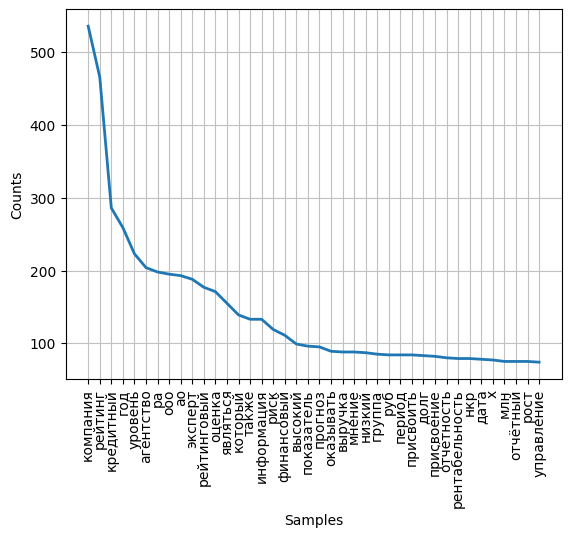

кредитный рейтинг ао лаут далее компания лаут обусловить высокий долгов нагрузка компания очень низкий показатель покрытие платёж долг слабый ликвидность поддержка уровень рейтинг попрежний оказывать сильный бизнеспрофиль компания ожидать вливание ликвидность сторона акционер текущий год сильный негативный влияние операционный деятельность компания следствие денежный поток оказать ограничение работа торговый центр ввести изз пандемия коронавирус статус рейтинг пересмотр развивающийся отражать мнение акр существенный влияние уровень кредитоспособность компания который мочь оказать ожидать поддержка сторона акционер лаут являться владелец оператор трц салариса общий площадь торговый центр составлять тыс кв м арендопригодный площадь тыс кв м лаут входить группа plaza bv далее группа который заниматься инвестиционный деятельность девелопмент эксплуатация управление коммерческий недвижимость проект группа трц салариса трц павелецкий плаз мфк columbus ключевой фактор рейтинговый оценка восст

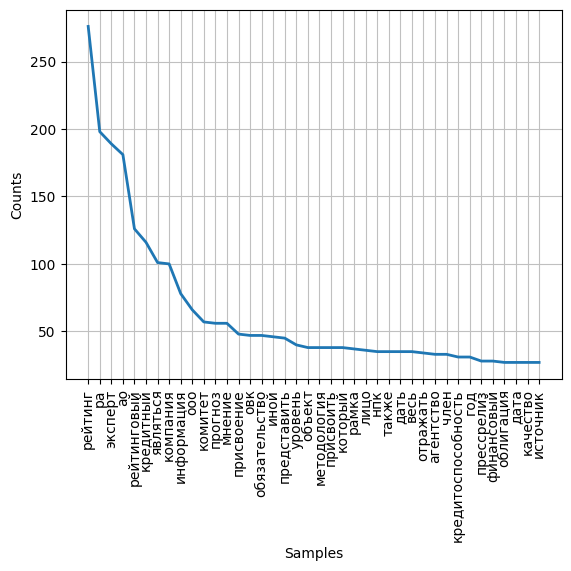

In [135]:
top_list = []
for rate in data['Уровень рейтинга'].unique():
    print(i)
    text_all = ''
    for i in data[data['Уровень рейтинга'] == rate].remove_stopwords:
        text_all += i

    text_tokens = word_tokenize(text_all)
    text_all = nltk.Text(text_tokens)
    fdist = FreqDist(text_all)
    #top 40 words
    print(fdist.most_common(40))
    top_list.append(fdist.most_common(50))
    fdist.plot(40,cumulative=False)

In [136]:
for i in range(len(top_list)):
    for w in range(len(top_list[i])):
        top_list[i][w] = top_list[i][w][0]

In [137]:
for i in range(len(top_list)):
    top_list[i].remove('рейтинг')
    top_list[i].remove('год')
    top_list[i].remove('компания')
    top_list[i].remove('кредитный')


In [139]:
for i in range(len(top_list)):
    try:
        top_list[i].remove('х')
    except:
        Exception

    try:
        top_list[i].remove('г')
    except:
        Exception

    try:
        top_list[i].remove('также')
    except:
        Exception

    try:
        top_list[i].remove('руб')
    except:
        Exception



In [141]:
len(top_list)

17

In [143]:
'ао' in top_list[0]

True

In [144]:
def word_rate0(x, n_rate):
    num_rate = 0
    for i in x.split(' '):
        if i in top_list[n_rate]:
            num_rate += 1
    return num_rate



In [146]:
data['top_w_rate0'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 0))
data['top_w_rate1'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 1))
data['top_w_rate2'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 2))
data['top_w_rate3'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 3))
data['top_w_rate4'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 4))
data['top_w_rate5'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 5))
data['top_w_rate6'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 6))
data['top_w_rate7'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 7))
data['top_w_rate8'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 8))
data['top_w_rate9'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 9))
data['top_w_rate10'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 10))
data['top_w_rate11'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 11))
data['top_w_rate12'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 12))
data['top_w_rate13'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 13))
data['top_w_rate14'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 14))
data['top_w_rate15'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 15))
data['top_w_rate16'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 16))


In [147]:
data

,Id,pr_txt,Категория,Уровень рейтинга,remove_stopwords,positive,negative,top_w_rate0,top_w_rate1,top_w_rate2,...,top_w_rate7,top_w_rate8,top_w_rate9,top_w_rate10,top_w_rate11,top_w_rate12,top_w_rate13,top_w_rate14,top_w_rate15,top_w_rate16
0,1,Повышение кредитного рейтинга Акционерного об...,A,A,повышение кредитный рейтинг акционерный общест...,71,32,176,169,163,...,175,147,128,143,166,192,139,158,144,70
1,2,«Эксперт РА» подтвердил кредитный рейтинг комп...,BB,BB,эксперт ра подтвердить кредитный рейтинг компа...,33,21,228,234,196,...,233,235,238,231,238,213,227,216,245,222
2,3,"НКР повысило кредитный рейтинг ООО ""ОТЭКО-Порт...",A,A,нкр повысить кредитный рейтинг ооо отэкопортсе...,63,42,199,228,167,...,204,210,206,208,202,227,216,172,226,147
3,4,«Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...,AAA,AAA,эксперт ра присвоить кредитный рейтинг пао фос...,61,39,291,274,273,...,286,306,312,303,299,265,247,312,298,254
4,5,29 марта 2023 г. Ведущий рейтинговый аналитик ...,BBB,BBB,март г ведущий рейтинговый аналитик юров алла ...,36,19,151,156,135,...,162,161,163,162,159,153,206,149,162,136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1207,«Эксперт РА» подтвердил рейтинг компании «Татн...,AAA,AAA,эксперт ра подтвердить рейтинг компания татнеф...,31,13,213,195,205,...,210,219,218,216,212,186,185,228,207,225
1196,1208,«Эксперт РА» понизил рейтинг компании «Инвестг...,BB,BB,эксперт ра понизить рейтинг компания инвестгео...,37,27,234,220,205,...,238,237,232,241,233,205,216,244,219,212
1197,1209,АКРА подтвердило ПАО «КАМАЗ» кредитный рейтинг...,A,A+,акр подтвердить пао камаз кредитный рейтинг пр...,56,31,181,143,222,...,165,169,114,153,164,174,121,183,123,67
1198,1210,АКРА подтвердило кредитный рейтинг ФГУП «Почта...,AAA,AAA,акр подтвердить кредитный рейтинг фгуп почта р...,50,22,131,131,199,...,138,128,120,160,143,149,123,157,129,84


In [148]:
data.to_excel('/content/drive/My Drive/hacks/hack_nizh/data_w_rate.xlsx')

# Сделаем фичи, означающие наличие позитивных или негативных слов

In [45]:
positive = ['высокий',
            "рост",
            "выручка", "рентабельность", "чистый",
            "ликвидность", "ffo", "ebitda"]

negative = ['долг', "риск", "снижение", "низкий"]

In [47]:
frec_razm = pd.read_excel('/content/drive/My Drive/hacks/hack_nizh/frec_razm.xlsx')

положительные слова

In [53]:
for w in frec_razm[frec_razm['Unnamed: 3'] == 1].word:
    positive.append(w)

In [56]:
len(positive)

46

In [59]:
positive

['высокий',
 'рост',
 'выручка',
 'рентабельность',
 'чистый',
 'ликвидность',
 'ffo',
 'ebitda',
 'позитивный',
 'кредитоспособность',
 'погашение',
 'сильный',
 'долгосрочный',
 'эмиссия',
 'увеличение',
 'мсфо',
 'положительный',
 'умеренный',
 'положительно',
 'улучшение',
 'доход',
 'инвестиция',
 'дивиденд',
 'дочерний',
 'мировой',
 'привлечение',
 'сделка',
 'комфортный',
 'хороший',
 'качественный',
 'диверсифицировать',
 'oibda',
 'получение',
 'доступный',
 'поступление',
 'высоко',
 'успешный',
 'снизить',
 'развивающийся',
 'благоприятный',
 'прирост',
 'согласовать',
 'наращивать',
 'укрепление',
 'рефинансировать',
 'стабилизация']

негативные слова

In [57]:
for w in frec_razm[frec_razm['Unnamed: 3'] == 0].word:
    negative.append(w)

In [58]:
len(negative)

36

In [60]:
negative

['долг',
 'риск',
 'снижение',
 'низкий',
 'долгов',
 'долговой',
 'продажа',
 'негативный',
 'налог',
 'последствие',
 'краткосрочный',
 'риска',
 'превышать',
 'ухудшение',
 'задолженность',
 'сокращение',
 'падение',
 'необеспеченный',
 'слабый',
 'запретить',
 'убыток',
 'превысить',
 'потеря',
 'издержка',
 'просрочить',
 'неопределённость',
 'износ',
 'несубординировать',
 'нарушение',
 'загрузка',
 'ослабление',
 'дефолт',
 'дефицит',
 'санкция',
 'превышение',
 'недостаток']

In [61]:
data.head()

,Unnamed: 0,Id,pr_txt,Категория,Уровень рейтинга,remove_stopwords
0,0,1,Повышение кредитного рейтинга Акционерного об...,A,A,повышение кредитный рейтинг акционерный общест...
1,1,2,«Эксперт РА» подтвердил кредитный рейтинг комп...,BB,BB,эксперт ра подтвердить кредитный рейтинг компа...
2,2,3,"НКР повысило кредитный рейтинг ООО ""ОТЭКО-Порт...",A,A,нкр повысить кредитный рейтинг ооо отэкопортсе...
3,3,4,«Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...,AAA,AAA,эксперт ра присвоить кредитный рейтинг пао фос...
4,4,5,29 марта 2023 г. Ведущий рейтинговый аналитик ...,BBB,BBB,март г ведущий рейтинговый аналитик юров алла ...


In [70]:
pos_rate = 0
neg_rate = 0
for i in data.remove_stopwords[100].split(' '):
    if i in positive:
        pos_rate += 1
    elif i in negative:
        neg_rate += 1

In [71]:
pos_rate

53

In [72]:
neg_rate

28

In [73]:
def negative_rate(x):
    neg_rate = 0
    for i in x.split(' '):
        if i in negative:
            neg_rate += 1
    return neg_rate

def positive_rate(x):
    pos_rate = 0
    for i in x.split(' '):
        if i in positive:
            pos_rate += 1
    return pos_rate

In [75]:
data['positive'] = data.remove_stopwords.apply(lambda x: positive_rate(x))
data['negative'] = data.remove_stopwords.apply(lambda x: negative_rate(x))

In [77]:
data.positive.max()

164

In [81]:
data.negative.max()

72

In [79]:
data.positive.min()

3

In [80]:
data.negative.min()

2

In [82]:
data.head(10)

,Unnamed: 0,Id,pr_txt,Категория,Уровень рейтинга,remove_stopwords,positive,negative
0,0,1,Повышение кредитного рейтинга Акционерного об...,A,A,повышение кредитный рейтинг акционерный общест...,71,32
1,1,2,«Эксперт РА» подтвердил кредитный рейтинг комп...,BB,BB,эксперт ра подтвердить кредитный рейтинг компа...,33,21
2,2,3,"НКР повысило кредитный рейтинг ООО ""ОТЭКО-Порт...",A,A,нкр повысить кредитный рейтинг ооо отэкопортсе...,63,42
3,3,4,«Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...,AAA,AAA,эксперт ра присвоить кредитный рейтинг пао фос...,61,39
4,4,5,29 марта 2023 г. Ведущий рейтинговый аналитик ...,BBB,BBB,март г ведущий рейтинговый аналитик юров алла ...,36,19
5,5,6,Кредитный рейтинг ПАО «ФосАгро» (далее — Комп...,AAA,AAA,кредитный рейтинг пао фосагро далее компания ф...,48,17
6,6,7,«Эксперт РА» повысил кредитный рейтинг ОАО «МР...,AA,AA+,эксперт ра повысить кредитный рейтинг оао мрск...,48,29
7,7,8,«Эксперт РА» понизил кредитный рейтинг ПАО «М....,A,A,эксперт ра понизить кредитный рейтинг пао мвид...,36,21
8,8,9,«Эксперт РА» повысил кредитный рейтинг компани...,BB,BB+,эксперт ра повысить кредитный рейтинг компания...,53,23
9,9,10,Кредитный рейтинг ООО «МВМ» (далее — Компани...,A,A,кредитный рейтинг ооо мвм далее компания мвм о...,14,11


In [83]:
data = data.drop('Unnamed: 0', axis=1)

In [84]:
data.to_excel('/content/drive/My Drive/hacks/hack_nizh/data_w_semantic.xlsx')